### 第4章画像分類

#### FNNモデルの実装

In [14]:
from collections import deque
import copy
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
from typing import Callable
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

# 外部モジュール
# import util
# import transform

In [22]:
# FNN(順伝播型ニューラルネットワークモデル)の実装
class FNN(nn.Module):
    """
    順伝播型ニューラルネットワーク
    dim_input         : 入力次元
    dim_hidden        : 特徴量次元
    num_hidden_layers : 隠れ層の数
    num_classes       : 分類対象の物体クラス数
    """
    def __init__(self, dim_input: int, dim_hidden: int,
                 num_hidden_layers: int, num_classes: int):
        super().__init__()
        
        """層の生成"""
        self.layers = nn.ModuleList()
        
        # 入力層->隠れ層
        self.layers.append(self._generate_hidden_layer(
            dim_input, dim_hidden
        ))
        
        # 隠れ層->隠れ層
        for _ in range(num_hidden_layers - 1):
            self.layers.append(self._generate_hidden_layer(
                dim_hidden, dim_hidden
            ))
        
        # 隠れ層->出力層
        self.linear = nn.Linear(dim_hidden, num_classes)
        """"""
        
    """
    隠れ層生成関数
    dim_input  : 入力次元
    dim_output : 出力次元
    """
    def _generate_hidden_layer(self, dim_input: int, dim_output: int):
        layer = nn.Sequential(
            nn.Linear(dim_input, dim_output, bias=False),
            nn.BatchNorm1d(dim_output),
            nn.ReLU(inplace=True)
        )
        
        return layer
    
    """
    順伝播関数
    x            : 入力, [バッチサイズ, 入力次元]
    return_embed : 特徴量(最後の全結合層を適用する前)を返すかロジット(全結合層を適用した値)を返すかを選択する真偽値 
    """
    def forward(self, x: torch.Tensor, return_embed: bool=False):
        h = x
        for layer in self.layers:
            h = layer(h)
            
        # return_embedがTrueの場合、特徴量を返す
        if return_embed:
            return h
        
        y = self.linear(h)
        
        # return_embedがFalseの場合、ロジットを返す
        return y
    
    """
    モデルパラメータは保持されているデバイスを返す関数
    """
    def get_device(self):
        return self.linear.weight.device # モデルを保持するデバイスを返す
    
    """
    モデルを複製して返す関数
    """
    def copy(self):
        return copy.deepcopy(self)
    

In [32]:
# 学習・評価におけるハイパーパラメータやオプションの設定
class Config:
    """
    ハイパーパラメータとオプションの設定
    """
    def __init__(self):
        self.var_ratio = 0.2 # 検証に使う学習セット内のデータの割合
        self.dim_hidden = 512 # 隠れ層の特徴量次元
        self.num_hidden_layers = 2 # 隠れ層の数
        self.num_epochs = 30 # 学習エポック数
        self.lr = 1e-2 # 学習率
        self.moving_avg = 20 # 移動平均で計算する損失と正確度の値の数
        self.batch_size = 32 # バッチサイズ
        self.num_workers = 2 # データローダに使うCPUの数
        self.device = 'cuda' # 学習に使うデバイス
        self.num_samples = 200 # t-SNEでプロットするサンプル数

In [33]:
# 評価関数
def evaluate(data_loader: DataLoader, model: nn.Module, loss_func: Callable):
    model.eval()
    
    losses = []
    preds = []
    for x, y in data_loader:
        with torch.no_grad():
            x = x.to(model.get_device())
            y = y.to(model.get_device())
            
            y_pred = model(x)
            
            losses.append(loss_func(y_pred, y, reduction='none'))
            preds.append(y_pred.argmax(dim=1) == y)
            
    loss = torch.cat(losses).mean()
    accuracy = torch.cat(preds).float().mean()
    
    return loss, accuracy

In [34]:
# t-SNEを使った特徴量のプロット関数
"""
t-SNEのプロット関数
data_loader : プロット対象のデータを読み込むデータローダ
model       : 特徴量抽出に使うモデル
num_samples : t-SNEでプロットするサンプル数
"""
def plot_t_sne(data_loader: DataLoader, model: nn.Module,
               num_samples: int):
    model.eval()
    
    # t-SNEのためのデータ整形
    x = []
    y = []
    for imgs, labels in data_loader:
        with torch.no_grad():
            imgs = imgs.to(model.get_device())
            
            # 特徴量の抽出
            embeddings = model(imgs, return_embed=True)
            
            x.append(embeddings.to('cpu'))
            y.append(labels.clone())
            
    x = torch.cat(x)
    y = torch.cat(y)
    
    # NumPy配列に変換
    x = x.numpy()
    y = y.numpy()
    
    # 指定サンプル数だけ抽出
    x = x[:num_samples]
    y = y[:num_samples]
    
    # t-SNEを適用
    t_sne = TSNE(n_components=2, random_state=42)
    x_reduced = t_sne.fit_transform(x)
    
    # 各ラベルとマーカーを設定
    cmap = plt.get_cmap("tab10")
    markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']
    
    # データをプロット
    plt.figure(figsize=(20, 15))
    for i, cls in enumerate(data_loader.dataset.classes):
        plt.scatter(x_reduced[y==i, 0], x_reduced[y==i, 1],
                    c=[cmap(i/len(data_loader.dataset.classes))],
                    marker=markers[i], s=500, alpha=0.6, label=cls)
        plt.axis('off')
        plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
    plt.show()

In [35]:
# 画像整形関数
"""
img         : 整形対象の画像
channel_mean: 各次元のデータセット全体の平均、[入力次元]
channel_std : 各次元のデータセット全体の標準偏差、[入力次元]  
"""
def transform(img: Image.Image, channel_mean: np.ndarray=None,
              channel_std: np.ndarray=None):
    # PILからNumPy配列に変換
    img = np.asarray(img, dtype='float32')
    
    # [32, 32, 3]の画像を3072次元のベクトルに平坦化
    x = img.flatten()
    
    # 各次元をデータセット全体の平均と標準偏差で正規化
    if channel_mean is not None and channel_std is not None:
        x = (x - channel_mean) / channel_std
    
    return x

# 各次元のデータセット全体の平均と標準偏差を計算する関数
"""
dataset: 平均と標準偏差を計算する対象のPytorchのデータセット
"""
def get_dataset_statistics(dataset: Dataset):
    data = []
    for i in range(len(dataset)):
        # 3072次元のベクトルを取得
        img_flat = dataset[i][0]
        data.append(img_flat)
    # 第0軸を追加して第0軸でデータを連結
    data = np.stack(data)
    
    # データ全体の平均と標準偏差を計算
    channel_mean = np.mean(data, axis=0)
    channel_std = np.std(data, axis=0)
    
    return channel_mean, channel_std

# データセットを2つに分割するインデックス集合を生成する関数
"""
dataset    : 分割対象のデータセット
ration     : 1つ目のセットに含めるデータ量の割合
random_seed: 分割結果を不変にするためのシード
"""
def generate_subset(
    dataset: Dataset, ration: float, random_seed: int=42):
    # サブセットの大きさを計算
    size = int(len(dataset) * ration)
    
    indices = list(range(len(dataset)))
    
    # 2つのセットに分ける前にシャッフル
    random.seed(random_seed)
    random.shuffle(indices)
    
    # セット1とセット2のサンプルのインデックスに分割
    indices1, indices2 = indices[:size], indices[size:]
    
    return indices1, indices2

# 学習・評価を行う関数
def train_eval():
    config = Config()
    
    # 入力データ正規化のため学習データセットを使って
    # 各次元の平均と標準偏差を計算
    dataset = torchvision.datasets.CIFAR10(
        root="../chapter3-data/", train=True, download=True,
        transform=transform
    )
    channel_mean, channel_std = get_dataset_statistics(dataset)
    
    # 正規化を含めた画像整形関数の用意
    img_transform = lambda x: transform(
        x, channel_mean, channel_std
    )
    
    # 学習、評価セットの用意
    train_dataset = torchvision.datasets.CIFAR10(
        root="../chapter3-data/", train=True, download=True,
        transform=img_transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root="../chapter3-data/", train=False, download=True,
        transform=img_transform
    )
    
    # 学習・検証セットへ分割するためのインデックス集合の生成
    val_set, train_set = generate_subset(train_dataset, config.var_ratio)
    
    print(f'学習セットのサンプル数： {len(train_set)}')
    print(f'検証セットのサンプル数: {len(val_set)}')
    print(f'評価セットのサンプル数: {len(test_dataset)}')
    
    # インデックス集合から無作為にインデックスをサンプルするサンプラー
    train_sampler = SubsetRandomSampler(train_set)
    
    # DataLoaderを生成
    train_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=train_sampler
    )
    val_loader = DataLoader(
        train_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers, sampler=val_set
    )
    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        num_workers=config.num_workers
    )
    
    # 目的関数の生成(交差エントロピー)
    loss_func = F.cross_entropy
    
    # 検証セットの結果による最良モデルの保存用変数
    val_loss_best = float('inf')
    model_best = None
    
    # FNNモデルの生成
    model = FNN(32 * 32 * 3, config.dim_hidden,
                config.num_hidden_layers,
                len(train_dataset.classes))
    
    # モデルを指定デバイスに転送(デフォルトCPU)
    model.to(config.device)
    
    # 最適化器の生成
    optimizer = optim.SGD(model.parameters(), lr=config.lr)
    
    for epoch in range(config.num_epochs):
        model.train()
        
        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック: {epoch+1}]')
            
            # 移動平均計算用
            losses = deque()
            accs = deque()
            for x, y in pbar:
                # データをモデルと同じデバイスに転送
                x = x.to(model.get_device())
                y = y.to(model.get_device())
                
                # 既に計算された勾配をリセット
                optimizer.zero_grad()
                
                # 順伝播
                y_pred = model(x)
                
                # 学習データに対する損失と正確度を計算
                loss = loss_func(y_pred, y)
                accuracy = (y_pred.argmax(dim=1) == y).float().mean()
                
                # 誤差逆伝播
                loss.backward()
                
                # パラメータ更新
                optimizer.step()
                
                # 移動平均を計算して表示
                losses.append(loss.item())
                accs.append(accuracy.item())
                if len(losses) > config.moving_avg:
                    losses.popleft()
                    accs.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(losses).mean().item(),
                    'accuracy': torch.Tensor(accs).mean().item()
                })
            
        # 検証セットを使って精度評価
        val_loss, val_accuracy = evaluate(
            val_loader, model, loss_func
        )
        print(f'検証: loss = {val_loss:.3f}, accuracy = {val_accuracy:.3f}')
        
        # より良い検証結果が得られたモデルを記録
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            model_best = model.copy()
            
    # test
    test_loss, test_accuracy = evaluate(
        test_loader, model_best, loss_func
    )
    print(f'テスト: loss = {test_loss}, accuracy = {test_accuracy}')
    
    # t_SNEを使って特徴量の分布をプロット
    plot_t_sne(test_loader, model_best, config.num_samples)
                
            
                

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
学習セットのサンプル数： 40000
検証セットのサンプル数: 10000
評価セットのサンプル数: 10000


[エポック: 1]: 100%|██████████| 1250/1250 [00:08<00:00, 155.11it/s, loss=1.55, accuracy=0.45] 


検証: loss = 1.478, accuracy = 0.477


[エポック: 2]: 100%|██████████| 1250/1250 [00:07<00:00, 157.68it/s, loss=1.45, accuracy=0.489]


検証: loss = 1.390, accuracy = 0.507


[エポック: 3]: 100%|██████████| 1250/1250 [00:07<00:00, 158.54it/s, loss=1.36, accuracy=0.533]


検証: loss = 1.358, accuracy = 0.522


[エポック: 4]: 100%|██████████| 1250/1250 [00:07<00:00, 159.25it/s, loss=1.29, accuracy=0.558]


検証: loss = 1.332, accuracy = 0.535


[エポック: 5]: 100%|██████████| 1250/1250 [00:08<00:00, 155.66it/s, loss=1.17, accuracy=0.591]


検証: loss = 1.318, accuracy = 0.539


[エポック: 6]: 100%|██████████| 1250/1250 [00:07<00:00, 158.86it/s, loss=1.18, accuracy=0.597]


検証: loss = 1.316, accuracy = 0.544


[エポック: 7]: 100%|██████████| 1250/1250 [00:08<00:00, 155.15it/s, loss=1.07, accuracy=0.62]  


検証: loss = 1.307, accuracy = 0.547


[エポック: 8]: 100%|██████████| 1250/1250 [00:07<00:00, 156.88it/s, loss=1.05, accuracy=0.647] 


検証: loss = 1.319, accuracy = 0.550


[エポック: 9]: 100%|██████████| 1250/1250 [00:07<00:00, 156.26it/s, loss=0.978, accuracy=0.666]


検証: loss = 1.367, accuracy = 0.536


[エポック: 10]: 100%|██████████| 1250/1250 [00:07<00:00, 158.96it/s, loss=0.955, accuracy=0.669]


検証: loss = 1.364, accuracy = 0.541


[エポック: 11]: 100%|██████████| 1250/1250 [00:07<00:00, 157.24it/s, loss=0.852, accuracy=0.703]


検証: loss = 1.362, accuracy = 0.548


[エポック: 12]: 100%|██████████| 1250/1250 [00:07<00:00, 156.39it/s, loss=0.885, accuracy=0.695]


検証: loss = 1.372, accuracy = 0.548


[エポック: 13]: 100%|██████████| 1250/1250 [00:07<00:00, 158.81it/s, loss=0.81, accuracy=0.697] 


検証: loss = 1.385, accuracy = 0.542


[エポック: 14]: 100%|██████████| 1250/1250 [00:08<00:00, 155.98it/s, loss=0.757, accuracy=0.725]


検証: loss = 1.393, accuracy = 0.555


[エポック: 15]: 100%|██████████| 1250/1250 [00:08<00:00, 154.18it/s, loss=0.681, accuracy=0.781]


検証: loss = 1.431, accuracy = 0.540


[エポック: 16]: 100%|██████████| 1250/1250 [00:07<00:00, 157.43it/s, loss=0.687, accuracy=0.761]


検証: loss = 1.475, accuracy = 0.541


[エポック: 17]: 100%|██████████| 1250/1250 [00:08<00:00, 155.31it/s, loss=0.666, accuracy=0.781]


検証: loss = 1.476, accuracy = 0.542


[エポック: 18]: 100%|██████████| 1250/1250 [00:07<00:00, 157.03it/s, loss=0.582, accuracy=0.786]


検証: loss = 1.486, accuracy = 0.540


[エポック: 19]: 100%|██████████| 1250/1250 [00:08<00:00, 153.82it/s, loss=0.571, accuracy=0.791]


検証: loss = 1.538, accuracy = 0.539


[エポック: 20]: 100%|██████████| 1250/1250 [00:07<00:00, 158.27it/s, loss=0.564, accuracy=0.797]


検証: loss = 1.528, accuracy = 0.540


[エポック: 21]: 100%|██████████| 1250/1250 [00:07<00:00, 166.95it/s, loss=0.503, accuracy=0.827]


検証: loss = 1.535, accuracy = 0.546


[エポック: 22]: 100%|██████████| 1250/1250 [00:07<00:00, 161.06it/s, loss=0.447, accuracy=0.872]


検証: loss = 1.552, accuracy = 0.551


[エポック: 23]: 100%|██████████| 1250/1250 [00:07<00:00, 157.30it/s, loss=0.506, accuracy=0.828]


検証: loss = 1.598, accuracy = 0.543


[エポック: 24]: 100%|██████████| 1250/1250 [00:08<00:00, 154.12it/s, loss=0.36, accuracy=0.883] 


検証: loss = 1.612, accuracy = 0.553


[エポック: 25]: 100%|██████████| 1250/1250 [00:07<00:00, 157.39it/s, loss=0.431, accuracy=0.839]


検証: loss = 1.663, accuracy = 0.542


[エポック: 26]: 100%|██████████| 1250/1250 [00:07<00:00, 156.40it/s, loss=0.44, accuracy=0.841] 


検証: loss = 1.727, accuracy = 0.527


[エポック: 27]: 100%|██████████| 1250/1250 [00:08<00:00, 154.42it/s, loss=0.444, accuracy=0.853]


検証: loss = 1.679, accuracy = 0.550


[エポック: 28]: 100%|██████████| 1250/1250 [00:07<00:00, 158.69it/s, loss=0.415, accuracy=0.85] 


検証: loss = 1.742, accuracy = 0.539


[エポック: 29]: 100%|██████████| 1250/1250 [00:07<00:00, 157.24it/s, loss=0.329, accuracy=0.898]


検証: loss = 1.708, accuracy = 0.547


[エポック: 30]: 100%|██████████| 1250/1250 [00:07<00:00, 157.21it/s, loss=0.345, accuracy=0.897]


検証: loss = 1.724, accuracy = 0.549
テスト: loss = 1.3120958805084229, accuracy = 0.535099983215332


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


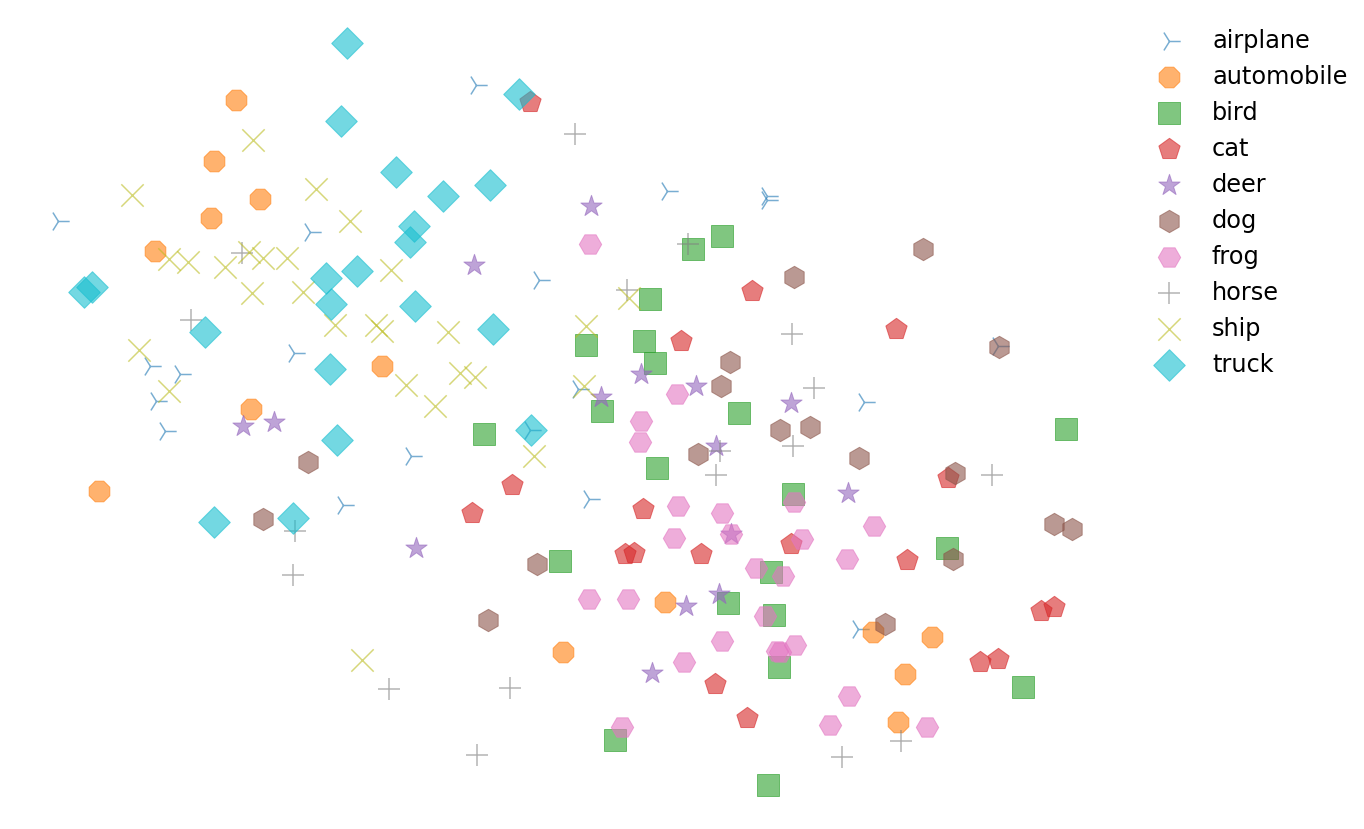

In [36]:
# 学習・評価の実行
train_eval()